In [10]:
import numpy as np
import keras
import wandb
import random
import tensorflow as tf
from wandb.keras import WandbCallback
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input
from keras.datasets import mnist
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [20]:
# load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [21]:
# make pairs
def make_pairs(x, y):
    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]
        
        pairs += [[x1, x2]]
        labels += [1]
    
        # add a not matching example
        label2 = random.randint(0, num_classes-1)
        while label2 == label1:
            label2 = random.randint(0, num_classes-1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]
        
        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels)

train_pairs, train_labels = make_pairs(x_train, y_train)
test_pairs, test_labels = make_pairs(x_test, y_test)

In [22]:
print(train_pairs.shape)
print(train_labels.shape)

(120000, 2, 28, 28)
(120000,)


1


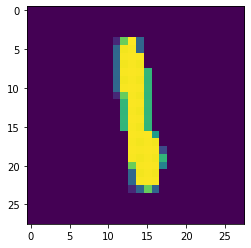

In [24]:
plt.imshow(train_pairs[400, 0])
print(train_labels[4])


### Building Simple Model

In [25]:
from keras import backend as K

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


input = Input((28,28))
x = Flatten()(input)
x = Dense(128, activation='relu')(x)
dense = Model(input, x)

input1 = Input((28,28))
input2 = Input((28,28))

dense1 = dense(input1)
dense2 = dense(input2)

merge_layer = Lambda(euclidean_distance)([dense1,dense2])
dense_layer = Dense(1, activation="sigmoid")(merge_layer)
model = Model(inputs=[input1, input2], outputs=dense_layer)

In [26]:
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
model_6 (Model)                 (None, 128)          100480      input_12[0][0]                   
                                                                 input_13[0][0]                   
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 1)            0           model_6[1][0]              

In [27]:
wandb.init(project="siamese")
model.fit([train_pairs[:,0], train_pairs[:,1]], train_labels[:], batch_size=16, epochs=10, callbacks=[WandbCallback()])

Epoch 1/10
7500/7500 [==============================] - 17s 2ms/step - loss: 0.4866 - accuracy: 0.7708
Epoch 2/10
7500/7500 [==============================] - 17s 2ms/step - loss: 0.4104 - accuracy: 0.8177
Epoch 3/10
7500/7500 [==============================] - 17s 2ms/step - loss: 0.4021 - accuracy: 0.8220
Epoch 4/10
7500/7500 [==============================] - 20s 3ms/step - loss: 0.3994 - accuracy: 0.8241 0s - loss:
Epoch 5/10
7500/7500 [==============================] - 27s 4ms/step - loss: 0.3981 - accuracy: 0.8239
Epoch 6/10
7500/7500 [==============================] - 24s 3ms/step - loss: 0.3971 - accuracy: 0.8237
Epoch 7/10
7500/7500 [==============================] - 38s 5ms/step - loss: 0.3956 - accuracy: 0.8264
Epoch 8/10
7500/7500 [==============================] - 34s 5ms/step - loss: 0.3949 - accuracy: 0.8254
Epoch 9/10
7500/7500 [==============================] - 24s 3ms/step - loss: 0.3944 - accuracy: 0.8263
Epoch 10/10
7500/7500 [==============================] - 27s 4

Retry attempt failed:
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/urllib3/connection.py", line 156, in _new_conn
    conn = connection.create_connection(
  File "/usr/lib/python3/dist-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/usr/lib/python3.8/socket.py", line 918, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/urllib3/connectionpool.py", line 665, in urlopen
    httplib_response = self._make_request(
  File "/usr/lib/python3/dist-packages/urllib3/connectionpool.py", line 376, in _make_request
    self._validate_conn(conn)
  File "/usr/lib/python3/dist-packages/urllib3/connectionpool.py", line 996, i

Error in callback <function _init_jupyter.<locals>.cleanup at 0x7fd88ce43040> (for post_run_cell):


KeyboardInterrupt: 